In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

In [52]:
prev_timesteps = 12
prediction_steps = 1
batch_size = 50

train = MoviaBusDataset('../data/train', interpolation=True, prev_timesteps=prev_timesteps, prediction_steps=prediction_steps)
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=prev_timesteps, prediction_steps=prediction_steps)

train.normalize()
test.normalize(train.mean, train.std)



In [53]:
train_DL = DataLoader(train, batch_size=batch_size, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

In [64]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[0]

class RNN(nn.Module):
    def __init__(self, num_hidden1):
        super(RNN, self).__init__()
    
        self.lstm = nn.LSTM(num_roads, num_roads, batch_first=True, num_layers=2)
        self.activation = nn.ReLU()
       # self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        n_batch = x.size()[0]
        hidden = (torch.randn(2, n_batch, num_roads),
                  torch.randn(2, n_batch, num_roads))
        #for t_i in range(num_timesteps):
        #    out, hidden = self.lstm(x[:,t_i,:].view(-1,1,num_roads),hidden)
        
        
        #x : [batch_size, timesteps, wayids]   
        out, hidden = self.lstm(x, hidden)
        #x = self.activation(self.l1(x))
      
        return out

net = RNN(100)

optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
criterion = nn.L1Loss()

In [65]:
net.train()
for epoch in range(100):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        output = net(batch['data'][:,:,:-1])[:,-1,:].squeeze()
        target = batch['target']

        optimizer.zero_grad()
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer.step()
  
        cur_loss.append(loss.item())
    
    print("epoch = %2i  loss = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), output.std().item()))

epoch =  0  loss = 0.757  output_std = 0.051
epoch =  1  loss = 0.754  output_std = 0.052
epoch =  2  loss = 0.752  output_std = 0.055
epoch =  3  loss = 0.749  output_std = 0.061
epoch =  4  loss = 0.745  output_std = 0.071
epoch =  5  loss = 0.741  output_std = 0.088
epoch =  6  loss = 0.736  output_std = 0.116
epoch =  7  loss = 0.729  output_std = 0.158
epoch =  8  loss = 0.723  output_std = 0.206
epoch =  9  loss = 0.717  output_std = 0.245
epoch = 10  loss = 0.713  output_std = 0.264
epoch = 11  loss = 0.710  output_std = 0.269
epoch = 12  loss = 0.707  output_std = 0.271
epoch = 13  loss = 0.704  output_std = 0.275
epoch = 14  loss = 0.702  output_std = 0.282
epoch = 15  loss = 0.699  output_std = 0.287
epoch = 16  loss = 0.697  output_std = 0.292
epoch = 17  loss = 0.695  output_std = 0.296
epoch = 18  loss = 0.692  output_std = 0.299
epoch = 19  loss = 0.690  output_std = 0.302
epoch = 20  loss = 0.687  output_std = 0.306
epoch = 21  loss = 0.685  output_std = 0.308
epoch = 22

In [66]:
net.eval()
for i, batch in enumerate(test_DL):
    
    output = net(batch['data'][:,:,:-1])[:,-1,:].squeeze()
    target = batch['target']
        
    output = (output + torch.tensor(train.mean))*torch.tensor(train.std)
    target = (target + torch.tensor(train.mean))*torch.tensor(train.std)
    
    loss = criterion(output,target)
    print(loss.item())

1.7284752130508423


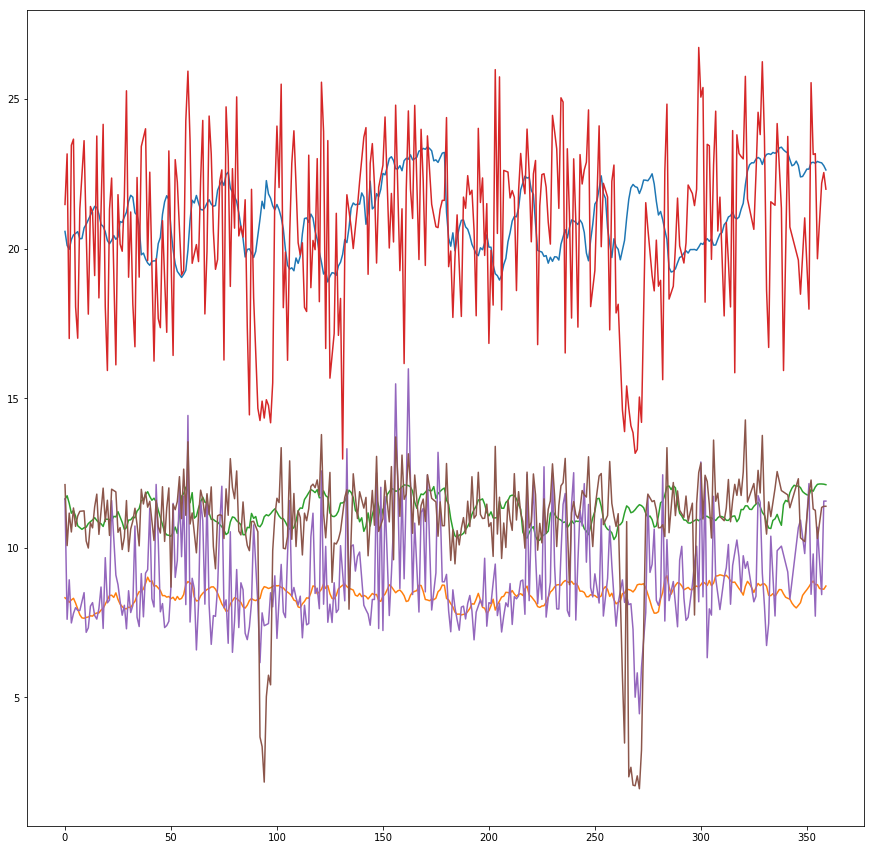

In [67]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

plt.plot(output[:,1:4].detach().numpy())
plt.plot(target[:,1:4].detach().numpy())